# Authors:
- Guijas Bravo, Pedro
- Miguélez Millos, Ángel

# Stream Processing: Amazon Stock Price Forecasting

## 1. Problem description

### Informal problem description

The goal of this project is to predict Amazon's future stock price from historical data, specifically using a daily time interval split. We want to know how Amazon's stock price will change in the future based on its past performance. This information can help investors make informed decisions about buying or selling Amazon stock.

Our goal is to develop a model that can learn from the real-time data stream and make accurate predictions about the future stock price. The model should be able to adapt to changing market conditions and adjust its predictions accordingly, using incremental learning models.

### Description of the problem characteristics from the ML viewpoint

- **What is the problem?** The problem is to predict future Amazon stock prices using daily historical data. The dataset is a data stream in which stock prices are continuously updated in real time. The data will be obtained using Yahoo Finance API, in open-high-low-close-close-volume (OHLCV) format, being the feature to predict the close price. Additionally, new features such as momentum will be computed to facilitate the training task by adding contextual information to the samples.

- **Is this problem one of clustering, regression, or classification?** This is a regression problem, the objective of which is to predict the future value of the stock, as mentioned above, using a daily time scale.

- **Is the dataset of the problem imbalanced?** The dataset is balanced. This is because during the price progression, there are multiple fluctuations that generate samples with both upward and downward micro trends.

- **Could the dataset of the problem be influenced by drift?** The dataset is influenced by concept drift as a multitude of external factors affect the price, making the sample distribution different in relation to time. Examples of factors that produce a concept drift would be news, crisis or speculation. In turn, the stock price can very a lot and follow different tendencies considering different years, months or even days.

- **How will model performance be evaluated? Are these metrics adequate?** The metric used to evaluate the regression model performance will be the root mean square error (RMSE). The main reason for this choice is that it allows the error to be expressed in terms of the same scale as the problem to be solved (in this case the stock price) and given that the objective of the models will be to predict future prices as accurately as possible.  Note that it has been decided to use RMSE over mean absolute error (MAE) because the latter is more robust than RMSE and therefore does not give as much importance to outliers. RMSE, on the other hand, gives more importance to outliers, being more sensitive to them.

- **Are there any relevant assumptions for this addressing the problem?** In principle, there are no relevant assumptions about the problem to be tackled. We can expect that the stock price will be very low for the initial samples, and very high in the last years due to 2 factors: the rapid globalization in the last decades that provoked the emergence of companies such as Amazon to provide resources to any part of the world as fast as possible, and the COVID-19 pandemic that increment the dependency towards online platforms over physical stores.

## 2. Dataset Selection

As already mentioned, the dataset to be employed is the OHLCV Amazon Stock Price via API. It should be emphasized the suitability of the same for the purposes of the practice, because from the point of view of incremental learning, the derived models will need to be updated and maintained to avoid their deterioration. The time factor will determine the socio-economic situation and this will consequently influence the price fluctuations of the stock markets. Therefore, the dataset is and will be composed of different distributions of characteristics or concept drifts, making it notorious the need for updating the model in favor of maintaining performance.

As for the dataset information, a brief preparation of the data will have to be carried out, including, apart from normalizations, the computation of new features useful for the models. The processing of the dataset will be discussed in the next section.

API endpoint: https://finance.yahoo.com (using the yfinance library)

### Import all the necessary libraries to perform the project

In [1]:
import collections
from datetime import date, datetime
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

#from rich import print

from river import compat, compose, drift, evaluate, feature_extraction, linear_model, metrics, preprocessing, stats, stream, utils 
from river.linear_model import BayesianLinearRegression
from river.neighbors import KNNRegressor
from river.neural_net import MLPRegressor
from river.neural_net.activations import ReLU, Identity
from river.tree import HoeffdingTreeRegressor, HoeffdingAdaptiveTreeRegressor

from tabulate import tabulate

import yfinance as yf

### Download Dataset

In [2]:
DATASET_PATH = "./AMZN.csv"

if not os.path.exists(DATASET_PATH):
    print("Downloading dataset...")
    df = yf.download('AMZN', start='1997-05-15', end='2023-02-17')  # fixed date for reproducibility issues
    df.to_csv(DATASET_PATH)

## 3. Data preparation

As it can be seen from the statistics obtained in the following cell, most of the features are real numbers (including the target), with the exception of date and market volume (integer). Therefore the data types are trivial derived from the meaning of the features. However, since they are not bounded it will be necessary to (zero mean) normalize them to facilitate the model learning process. The target (close) is also normalised to improve the training process and the performance of the models.

As for the computation of new features, the momentum or slope in the price progression will be calculated on the open value, which will give very useful information about the trend in the price. Since there are moments of rejection or indecision, the momentum for a given window size will also be averaged, allowing to obtain macro and micro trends. The date will be finally discarded and will only be used to determine when it is Monday (categorical, true or false), useful information due to the possible high volatility derived from weekend news or speculation. Adj Close will also be discarded.

Thus, all the features will be of type real (float) except for whether it is Monday. Notice that after normalization, volume will be also a float. The data types are inferred by the nature and meaning of the characteristics. 

A brief description of each (original or computed) feature is given below:
- Date: day to which is referred the sample.
- Open: the stock price at the beginning of the day (or when the market opens).
- Close: the stock price at the end of the day (or when the market closes).
- High: the maximum stock price of the day.
- Low: the lowest stock price of the day.
- Volume: the number of shares traded in the day.
- Adj Close: the closing price after adjustments for all applicable splits and dividend distributions.
- Momentum (open): tendency of the open value in a given window size.
- Is Monday: whether the date of the sample corresponds to Monday.

The next subsections correponds to the preparation of the dataset for the batch learning and the stream learning approach.

In [3]:
def read_dataset(data_path=DATASET_PATH):
    dataset = pd.read_csv(data_path)
    return dataset

# Check the dataset
dataset = read_dataset()
print(dataset.head(), end='\n\n')
print(dataset.tail(), end='\n\n')
print(dataset.describe(), end='\n\n')
print(dataset.dtypes)

         Date      Open      High       Low     Close  Adj Close      Volume
0  1997-05-15  0.121875  0.125000  0.096354  0.097917   0.097917  1443120000
1  1997-05-16  0.098438  0.098958  0.085417  0.086458   0.086458   294000000
2  1997-05-19  0.088021  0.088542  0.081250  0.085417   0.085417   122136000
3  1997-05-20  0.086458  0.087500  0.081771  0.081771   0.081771   109344000
4  1997-05-21  0.081771  0.082292  0.068750  0.071354   0.071354   377064000

            Date       Open        High        Low       Close   Adj Close  \
6479  2023-02-13  97.849998   99.680000  96.910004   99.540001   99.540001   
6480  2023-02-14  98.410004  100.919998  97.519997   99.699997   99.699997   
6481  2023-02-15  99.089996  101.169998  98.449997  101.160004  101.160004   
6482  2023-02-16  99.209999  100.629997  98.099998   98.150002   98.150002   
6483  2023-02-17  97.800003   97.940002  95.650002   97.199997   97.199997   

        Volume  
6479  52841500  
6480  56202900  
6481  48053900  


### Batch Learning data preparation

The reason for not using the same pipeline as for the stream approach is that we have experienced errors with ScikitLearn functions when the pipeline contains steps that look for some key (e.g. calculate the momentum on 'Open', discard 'Date'). Therefore, we had to calculate the features separately.

In [4]:
def compute_momentum(dataset, window_size=1):
    row_name = f"momentum_{window_size}d"
    dataset[row_name] = dataset['Open'].diff(periods=1)
    dataset[row_name] = dataset[row_name].rolling(window=window_size).mean()
    return dataset

def compute_is_monday(dataset):
    dataset['is_monday'] = pd.to_datetime(dataset['Date'])
    dataset['is_monday'] = dataset['is_monday'].apply(lambda x: x.weekday() == 0)
    return dataset

def read_batch_dataset(dataset_path=DATASET_PATH, momentum_windows=[1, 2, 4, 7], preview=False):
    
    # Read the dataset from the CSV file
    dataset = read_dataset(dataset_path)
    
    # Perform some feature engineering
    for w in momentum_windows:
        dataset = compute_momentum(dataset, window_size=w)
    dataset = dataset.fillna(0)
    
    dataset = compute_is_monday(dataset)
    
    # Print dataset information
    if preview:
        print(dataset.head(), end='\n\n')
        print(dataset.tail(), end='\n\n')
        print(dataset.describe(), end='\n\n')
        print(dataset.dtypes)
    
    dates = pd.to_datetime(dataset["Date"])  # useful information for future plots
    x = dataset[["Open", "High", "Low", "Volume", "momentum_1d", "momentum_2d", "momentum_4d", "momentum_7d", "is_monday"]]
    y = dataset["Close"]
    return x, y, dates

### Online Learning data preparation


In [5]:
# Functions to load the stream dataset
def datetime_converter(x):
    return datetime.strptime(x, '%Y-%m-%d')

def read_stream_dataset(dataset_path=DATASET_PATH):
    dataset = stream.iter_csv(dataset_path, 
                              target="Close",
                              converters={'Date': datetime_converter, 'Open':float, 'High':float, 
                                          'Close':float, 'Low':float, 'Volume':int, 'Adj Close':float}
                             )
    return dataset


# Classes and functions to compute features in the pipeline
class Momentum(stats.base.Univariate):
    def __init__(self, window_size=1):
        self.window_size = window_size
        self.buffer = collections.deque(maxlen=window_size)
        self.momentum = 0.0
        self.last_value = 0.0
        self.buffer.append(self.momentum)

    def update(self, x):
        momentum = x - self.last_value
        self.last_value = x
        self.buffer.append(momentum)
        self.momentum = np.mean(self.buffer)
        return self

    def get(self):
        return self.momentum

    @property
    def name(self):
        return f"momentum-{self.window_size}d"
    
    
# River models do not work properly with substracting operations
# involving booleans so we need to change the type of the feature
# 'is_monday' depending on the model (e.g. float for MLPRegressor)
def is_monday(x):
    weekday = x['Date'].weekday() 
    return weekday == 0

def is_monday_float(x):
    return {'is_monday': float(is_monday(x))}

def is_monday_bool(x):
    return {'is_monday': bool(is_monday(x))}

def build_stream_pipeline(numerical_monday=False):

    # Build the pipeline
    pipeline = compose.Select("Date", "Open", "High", "Low", "Volume")

    # Compute momentum
    for w in (1, 2, 4, 7, 14):
        pipeline += feature_extraction.Agg(by=None, how=Momentum(window_size=w), on="Open")
    
    # Standarize and compute if it is monday
    is_monday_func = is_monday_float if numerical_monday else is_monday_bool
    pipeline |= (compose.Select("Open", "High", "Low", "Volume", *[f"Open_momentum-{w}d" for w in (1,2,4,7)]) | preprocessing.StandardScaler()) + is_monday_func
    pipeline |= compose.Discard("Date") # not needed, but kept for safety
    
    return pipeline

## 4. Data drifts

The company's situation, the socio-economic state or any other external element affects the price of a company's shares. These situations will consequently depend on the time factor and transitively the dataset will present a changing distribution in its characteristics and targets. This is known as concept drift and now the concept drift on the dataset will be analyzed.

A priori, it is worth mentioning that the data set presents what is called real concept drift, since over time the probability of the target given the characteristics (P(Y|X)) changes. In addition, the probability of occurrence of certain values of the features P(X) will also change (aka virtual concept drift). This occurs, for example, in times of high speculation and economic prosperity, when really high values and volumes of shares will be observed compared to other time intervals.

In the price progress with daily temporality there will be multiple types of variations in the data distribution. Mostly incrementally, but also abruptly due to really shocking news about the market (e.g. pandemic situation). As a curiosity it should be noted the peculiar tendency of stock markets to repeat behavior (recurrent concepts) in what are called market fractals.

Regarding the concept drift detectors used, River provides a brief list of implemented detectors, these are: ADWIN (Adaptive Windowing), KSWIN (Kernel Change-Point Detection with Sliding Windows) and PageHinkley. All of these have detected different changes in the data distribution, however, with the exception of ADWIN, the results have not been entirely satisfactory. It should be noted that the detection process has been entirely based on an empirical process, and the results obtained are briefly summarized:
- `drift.ADWIN(delta=1e-20)`: Different delta values have been tested, the best being 1e-20. With this value, results close to those expected are obtained, detecting changes in the data distribution with a great balance between early detection and a low false positive rate.
- `drift.PageHinkley(delta=1e-40, min_instances=400, threshold=60)`: With this variation of the cumulative sum algorithm (CUSUM) we have not been able to obtain detections as good as in ADWIN for any parameter setting, having to abuse min_instances to avoid the high false positive rate.
- `drift.KSWIN(alpha=1e-10, window_size=300, seed=1)`: Although the detections are actually superior to those obtained with PageHinkley, those obtained with ADWIN are considered to be of superior quality.

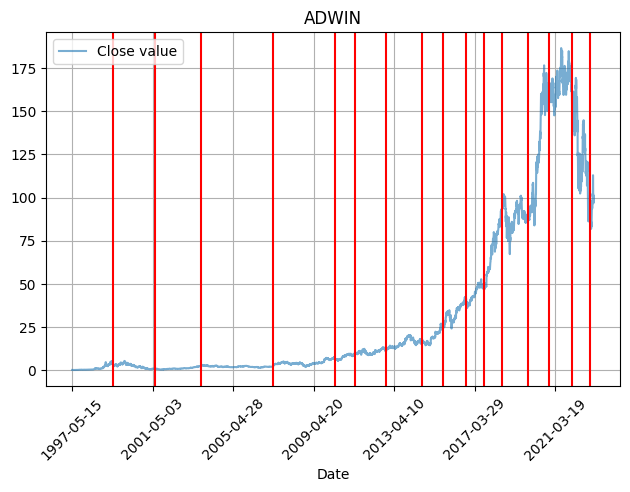

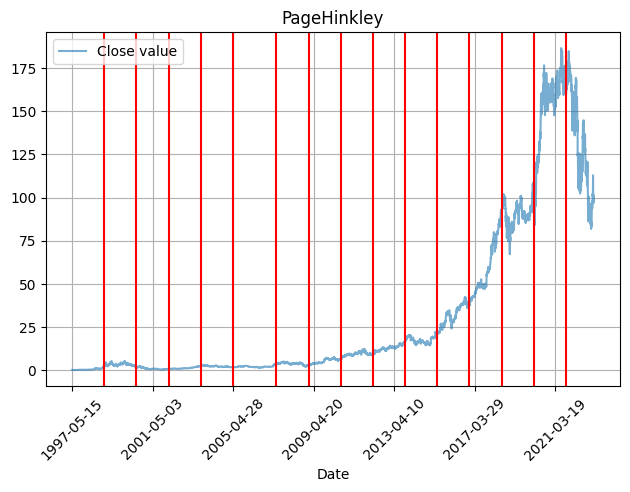

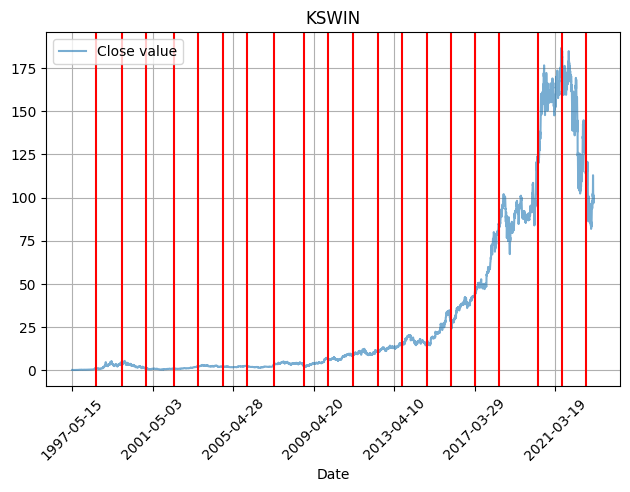

In [6]:
def plot_data(streams, x='Date', y='Close', labels=None, drifts=None, title=None):
    # Plot data
    ax0 = None
    for idx, stream in enumerate(streams):
        if ax0 is None:
            ax0 = stream.plot(x=x, y=y, label=labels[idx], alpha=0.6)
        else:
            stream.plot(x=x, y=y, ax=ax0, label=labels[idx], alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.legend()
    
    # Plot title
    if title is not None:
        plt.title(title)

    # Plot drifts detected
    if drifts is not None:
        for drift_detected in drifts:
            plt.axvline(drift_detected, color='red')
            
    plt.show()

def compute_and_plot_drifts(data, drift_detectors):
    for drift_detector in drift_detectors:
        # Compute drifts
        drifts = []
        for i, val in enumerate(data['Close']):
            drift_detector.update(val)
            if drift_detector.drift_detected:
                drifts.append(i)

        # Plot drifts
        plot_data([data], drifts=drifts, title=drift_detector.__class__.__name__, labels=['Close value'])

data = read_dataset()
drift_detectors = [drift.ADWIN(delta=1e-20), drift.PageHinkley(delta=1e-40, min_instances=400, threshold=60), drift.KSWIN(alpha=1e-10, window_size=300, seed=1)]
compute_and_plot_drifts(data, drift_detectors)

## 5. Batch learning

As mentioned previously, the river pipeline exported to scikit will not be used due to a library bug with accessing elements by field name. Thus, this part will not be processed in the pipeline itself, but will be removed and computed with its own code. Therefore, the normalization and the model in river's native pipeline for batch learning are highlighted. As for the models and parameter settings, using a cross-validation and a specific split for time series (`TimeSeriesSplit`), different parameters will be tested trying to find the best ones. The search for the optimal configurations will be done by using the `search_params` function which through a crude approach determines the best configurations. Finally, for the best configurations of each model, a classical Hold Out training is performed to graphically display the results and performance of these best models.

Note that in the conclusions section, the performance of these models will be discussed, comparing them with the Stream Learning based alternatives.


In [7]:
# Progress bar print function (stack overflow)
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'{prefix} |{bar}| {percent}% {suffix}', end=printEnd)
    
    # Print New Line on Complete
    if iteration == total: 
        print()


def search_params(fun, default_params, test_params):
 
    # Progress tracker variables
    exec_steps = np.prod([len(x) for x in test_params.values()])
    exec_progress = 0
 
    # Compute results
    results = []
 
    # Params
    params = default_params.copy()
    headers = list(test_params.keys()) + ['result']
 
    # Create pair combinations
    test_params = [[(p_name,v)for v in p_values] for p_name,p_values in test_params.items()]
 
 
    for p_conf in product(*test_params):
 
        # set params
        for param,value in p_conf:
            params[param] = value
 
        res = fun(**params)
        results.append([params[h][0] if isinstance(params[h], tuple) else params[h] for h in headers[:-1]] + [res])
 
        # Print progress
        exec_progress += 1
        printProgressBar(exec_progress, exec_steps, prefix = 'Progress:', length = 50)        
 
    # Show results
    print(tabulate(results, headers=headers))
    print()

In [8]:
def split_and_build_pipeline_batch(model, normalize_target=True, ptest=0.2, **model_params):
    
    # Read dataset from CSV file
    x, y, dates = read_batch_dataset(DATASET_PATH, preview=False)

    # Hold out 20% of the most recent data to test the final selected model
    train_idx = int(len(y) * (1 - ptest))
    x_train, y_train = x.iloc[:train_idx, :], y[:train_idx]
    x_test, y_test = x.iloc[train_idx:, :], y[train_idx:]

    avg, std = np.mean(y_train), np.std(y_train)
    if normalize_target:
        y_train = (y_train - avg) / std

    # Prepare the pipeline
    pipeline = preprocessing.StandardScaler()

    if model == BayesianLinearRegression:
        pipeline |= BayesianLinearRegression(alpha=model_params["alpha"], beta=model_params["beta"])
    elif model == KNNRegressor:
        pipeline |= KNNRegressor(n_neighbors=model_params["n_neighbors"])
    elif model == HoeffdingTreeRegressor:
        pipeline |= HoeffdingTreeRegressor(grace_period=model_params["grace_period"], max_depth=model_params["max_depth"])
    elif model == HoeffdingAdaptiveTreeRegressor:
        pipeline |= HoeffdingAdaptiveTreeRegressor(grace_period=model_params["grace_period"], max_depth=model_params["max_depth"], seed=1)
    elif model == MLPRegressor:
        pipeline |= MLPRegressor(hidden_dims=model_params["hidden_dims"][0], activations=model_params["hidden_dims"][1], seed=1)

    #print(pipeline.debug_one(x_train.iloc[0, :]))
    pipeline = compat.convert_river_to_sklearn(pipeline)
    
    # TODO: convert to a more handy structure (dict)
    return pipeline, x_train, y_train, x_test, y_test, dates, avg, std
    
    
def cross_validate_batch(model, normalize_target=True, ptest=0.2, n_splits=10, gap=7, **model_params):
    
    pipeline, x_train, y_train, _, _ , _, _, std= split_and_build_pipeline_batch(model, normalize_target, ptest, **model_params)
    
    # Use a timeseries cross-validation approach, where the test (validation)
    # set corresponds to the most recent samples
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)
    scores = cross_val_score(pipeline, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
    
    return f"{-scores.mean()*std:.4f} ± {scores.std()*std:.4f}"


def full_train_batch(model, normalize_target=True, ptest=0.2, **model_params):
    
    pipeline, x_train, y_train, x_test, y_test, dates, avg, std = split_and_build_pipeline_batch(model, normalize_target, ptest, **model_params)
        
    # Fit on the whole train set
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    
    if normalize_target:
        y_pred = y_pred * std + avg
        
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    # Plot results
    test_dates = dates.iloc[len(dates)-len(y_test):]
    df_pred = pd.DataFrame({"Date": test_dates, "Close": y_pred})
    df_true = pd.DataFrame({"Date": test_dates, "Close": y_test})
    plot_data([df_pred, df_true], labels=["Predicted Close", "Real Close"])

    return f"{rmse:.4f}"

### Hyperparameter tuning with cross-validation

In [9]:
# Default params
params = {
    'normalize_target': True,
    'ptest': 0.2,
    'n_splits': 10,
    'gap': 7,
}

####################################
#    Bayesian Linear Regression    #
####################################
params_2_test_bayesian = {
    'alpha': [1, 10, 100],
    'beta': [1, 10, 100]
}
bayesian_cv = lambda **params: cross_validate_batch(BayesianLinearRegression, **params)
print("Bayesian Linear Regression")
search_params(bayesian_cv, params, params_2_test_bayesian) 

########################
#    KNN Regression    #
########################
params_2_test_knn = {
    'n_neighbors': [3, 5, 7, 9, 11]
}
knn_cv = lambda **params: cross_validate_batch(KNNRegressor, **params)
print("KNN Regression")
search_params(knn_cv, params, params_2_test_knn)

########################
#    Hoeffding Tree    #
########################
params_2_test_hoeffding = {
    'grace_period': [50, 100, 250, 500],
    'max_depth': [1, 2, 3, 10, None]
}
hoeffding_cv = lambda **params: cross_validate_batch(HoeffdingTreeRegressor, **params)
print("Hoeffding Tree")
search_params(hoeffding_cv, params, params_2_test_hoeffding)

#################################
#    Hoeffding Adaptive Tree    #
#################################
params_2_test_hoeffding_adaptive = {
    'grace_period': [50, 100, 250, 500],
    'max_depth': [1, 2, 3, 10, None]
}
hoeffding_adaptive_cv = lambda **params: cross_validate_batch(HoeffdingAdaptiveTreeRegressor, **params)
print("Hoeffding Adaptive Tree")
search_params(hoeffding_adaptive_cv, params, params_2_test_hoeffding_adaptive)

######################
#    MLP Regression  #
######################
params_2_test_mlp = {
    'hidden_dims': [((), (ReLU, Identity)),
                    ((4,),(ReLU, ReLU, Identity)), ((16,),(ReLU, ReLU, Identity)), ((64,),(ReLU, ReLU, Identity)),
                    ((4, 4),(ReLU, ReLU, ReLU, Identity)), ((16, 4),(ReLU, ReLU, ReLU, Identity)), ((16, 16),(ReLU, ReLU, ReLU, Identity))]
}
mlp_cv = lambda **params: cross_validate_batch(MLPRegressor, **params)
print("MLP Regression")
search_params(mlp_cv, params, params_2_test_mlp)

Bayesian Linear Regression
Progress: |██████████████████████████████████████████████████| 100.0% 
  alpha    beta  result
-------  ------  ---------------
      1       1  5.4894 ± 2.3131
      1      10  6.1586 ± 1.9776
      1     100  6.4987 ± 1.4407
     10       1  7.2683 ± 3.6766
     10      10  5.4894 ± 2.3131
     10     100  6.1586 ± 1.9776
    100       1  8.3957 ± 6.2619
    100      10  7.2683 ± 3.6766
    100     100  5.4894 ± 2.3131

KNN Regression
Progress: |██████████████████████████████████████████████████| 100.0% 
  n_neighbors  result
-------------  ---------------
            3  2.8598 ± 3.6780
            5  2.9017 ± 3.7362
            7  2.9389 ± 3.7818
            9  2.9720 ± 3.8279
           11  3.0035 ± 3.8736

Hoeffding Tree
Progress: |██████████████████████████████████████████████████| 100.0% 
  grace_period    max_depth  result
--------------  -----------  ----------------
            50            1  2.8090 ± 6.4821
            50            2  2.7951 ± 6

### Fit in the whole training set and evaluate on the test set

Bayesian Linear Regression


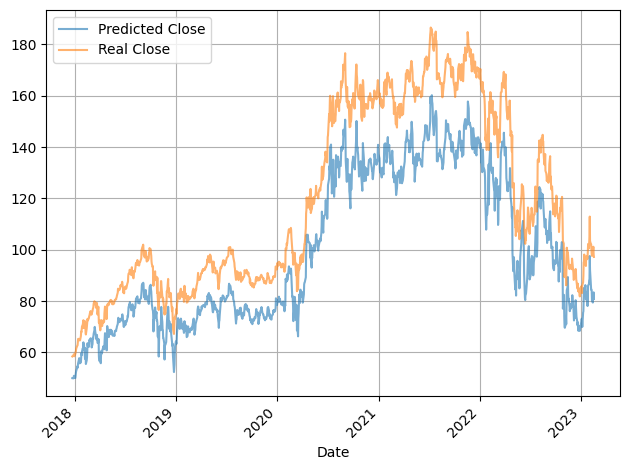

Progress: |██████████████████████████████████████████████████| 100.0% 
  alpha    beta    result
-------  ------  --------
      1       1   20.2099

KNN Regression


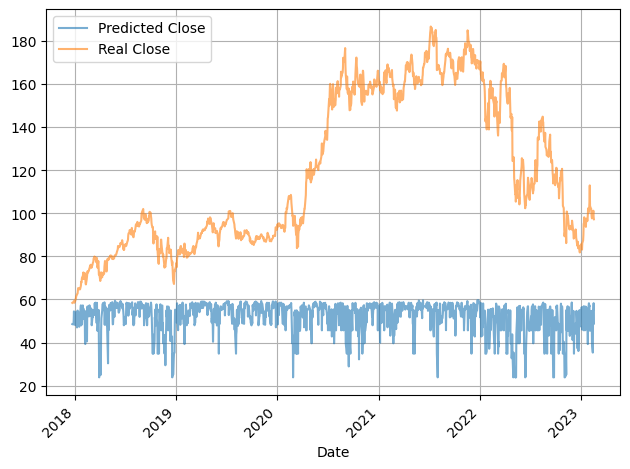

Progress: |██████████████████████████████████████████████████| 100.0% 
  n_neighbors    result
-------------  --------
            3   75.9289

Hoeffding Tree


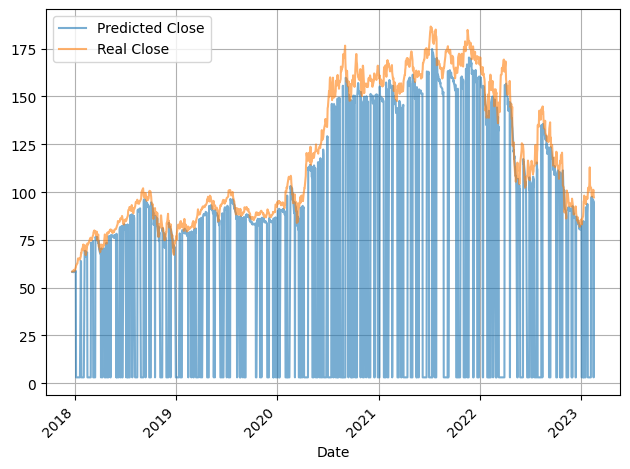

Progress: |██████████████████████████████████████████████████| 100.0% 
  grace_period    max_depth    result
--------------  -----------  --------
           500            1   78.0528

Hoeffding Adaptive Tree


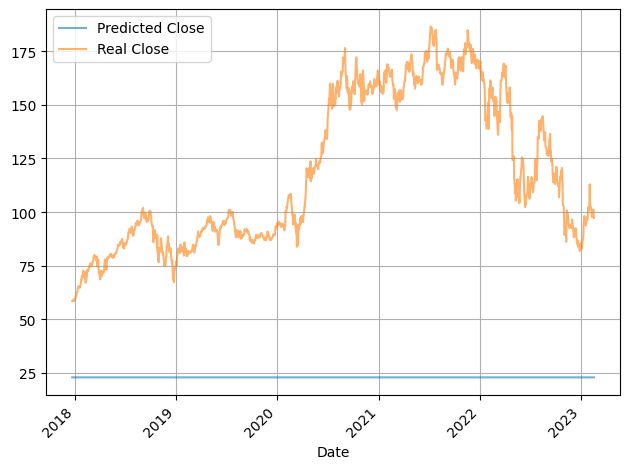

Progress: |██████████████████████████████████████████████████| 100.0% 
  grace_period    max_depth    result
--------------  -----------  --------
            50           10   102.484

MLP Regression


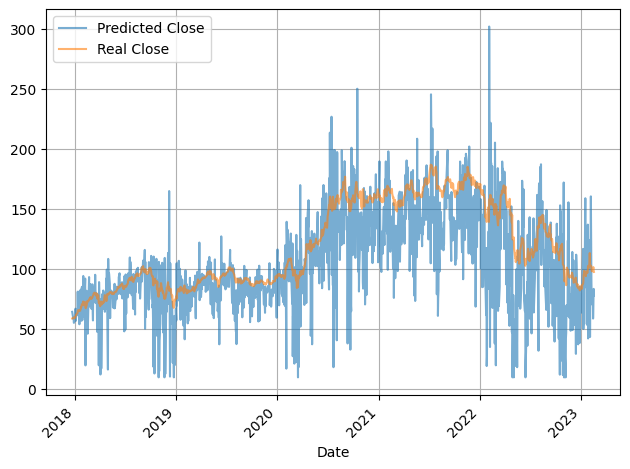

Progress: |██████████████████████████████████████████████████| 100.0% 
hidden_dims      result
-------------  --------
(4, 4)          33.6471



In [10]:
# Default params
params = {
    'normalize_target': True,
    'ptest': 0.2
}

####################################
#    Bayesian Linear Regression    #
####################################
params_2_test_bayesian = {
    'alpha': [1],
    'beta': [1]
}
bayesian_cv = lambda **params: full_train_batch(BayesianLinearRegression, **params)
print("Bayesian Linear Regression")
search_params(bayesian_cv, params, params_2_test_bayesian) 

########################
#    KNN Regression    #
########################
params_2_test_knn = {
    'n_neighbors': [3]
}
knn_cv = lambda **params: full_train_batch(KNNRegressor, **params)
print("KNN Regression")
search_params(knn_cv, params, params_2_test_knn)

########################
#    Hoeffding Tree    #
########################
params_2_test_hoeffding = {
    'grace_period': [500],
    'max_depth': [1]
}
hoeffding_cv = lambda **params: full_train_batch(HoeffdingTreeRegressor, **params)
print("Hoeffding Tree")
search_params(hoeffding_cv, params, params_2_test_hoeffding)

#################################
#    Hoeffding Adaptive Tree    #
#################################
params_2_test_hoeffding_adaptive = {
    'grace_period': [50],
    'max_depth': [10]
}
hoeffding_adaptive_cv = lambda **params: full_train_batch(HoeffdingAdaptiveTreeRegressor, **params)
print("Hoeffding Adaptive Tree")
search_params(hoeffding_adaptive_cv, params, params_2_test_hoeffding_adaptive)

######################
#    MLP Regression  #
######################
params_2_test_mlp = {
    'hidden_dims': [((4, 4), (ReLU, ReLU, ReLU, Identity))]
}
mlp_cv = lambda **params: full_train_batch(MLPRegressor, **params)
print("MLP Regression")
search_params(mlp_cv, params, params_2_test_mlp)

## 6. Stream learning

Regarding the stream learning, data preparation stages will be included in the pipeline, which will add new features to the samples and perform a standardization. The pipeline will finally include a model (multiple models are tested). Similarly to the batch learning section, different parameter configurations are evaluated trying to find the best combination of parameters. Finally, the performances and results of the best configurations for each Stream Learning model tested will be shown.

Note again that the results will be analyzed and compared in the last sections of the notebook.

### Test different configurations

In [13]:
def stream_validate(model, normalize_target=True, plot_results=False, **model_params):
    
    # Read dataset from CSV file
    ds_stream = read_stream_dataset()

    # Prepare the pipeline
    pipeline = build_stream_pipeline(numerical_monday=(model == MLPRegressor))

    if model == BayesianLinearRegression:
        model = BayesianLinearRegression(alpha=model_params["alpha"], beta=model_params["beta"])
    elif model == KNNRegressor:
        model = KNNRegressor(n_neighbors=model_params["n_neighbors"])
    elif model == HoeffdingTreeRegressor:
        model = HoeffdingTreeRegressor(grace_period=model_params["grace_period"], max_depth=model_params["max_depth"])
    elif model == HoeffdingAdaptiveTreeRegressor:
        model = HoeffdingAdaptiveTreeRegressor(grace_period=model_params["grace_period"], max_depth=model_params["max_depth"], seed=1)
    elif model == MLPRegressor:
        model = MLPRegressor(hidden_dims=model_params["hidden_dims"][0], activations=model_params["hidden_dims"][1], seed=1)

    pipeline |= preprocessing.TargetStandardScaler(model) if normalize_target else model
    #print(pipeline.debug_one(next(ds_stream)[0]))
    
    # Develop a custom loop to store the results at each timestep
    y_preds = pd.DataFrame(columns=["Date", "Close"])
    y_true = pd.DataFrame(columns=["Date", "Close"])

    rmse = metrics.RMSE()
    print_every = 500

    for idx, (x, y) in enumerate(ds_stream):

        # Predict and update the model and the metric
        y_pred = pipeline.predict_one(x)
        pipeline.learn_one(x, y)
        rmse.update(y, y_pred)

        # Save ground-truth and predicition
        y_preds.loc[len(y_preds)] = [x['Date'], y_pred]
        y_true.loc[len(y_true)] = [x['Date'], y]

        # Show RMSE value
        #if ((idx+1) % print_every == 0):
            #print(f"[{idx+1}] {rmse}")
        
    # Equivalent in a single line
    #rmse = evaluate.progressive_val_score(dataset=ds_stream, model=pipeline, metric=metrics.RMSE(), print_every=500)
    
    # Plot results
    if plot_results:
        train_idx = int(len(y_preds) * 0.8)  # magic number, assuming we used ptest=0.2 for batch learning
        plot_data([y_preds, y_true], labels=["Predicted Close", "Real Close"])
        plot_data([y_preds.iloc[train_idx:, :], y_true.iloc[train_idx:, :]], labels=["Predicted Close", "Real Close"])

    return f"{rmse.get():.4f}"

In [14]:
# Default params
params = {
    'normalize_target': True,
    'plot_results': False,
}

####################################
#    Bayesian Linear Regression    #
####################################
params_2_test_bayesian = {
    'alpha': [1, 10, 100],
    'beta': [1, 10, 100]
}
bayesian_cv = lambda **params: stream_validate(BayesianLinearRegression, **params)
print("Bayesian Linear Regression")
search_params(bayesian_cv, params, params_2_test_bayesian) 

########################
#    KNN Regression    #
########################
params_2_test_knn = {
    'n_neighbors': [3, 5, 7, 9, 11]
}
knn_cv = lambda **params: stream_validate(KNNRegressor, **params)
print("KNN Regression")
search_params(knn_cv, params, params_2_test_knn)

########################
#    Hoeffding Tree    #
########################
params_2_test_hoeffding = {
    'grace_period': [50, 100, 250, 500],
    'max_depth': [1, 2, 3, 10, None]
}
hoeffding_cv = lambda **params: stream_validate(HoeffdingTreeRegressor, **params)
print("Hoeffding Tree")
search_params(hoeffding_cv, params, params_2_test_hoeffding)

#################################
#    Hoeffding Adaptive Tree    #
#################################
params_2_test_hoeffding_adaptive = {
    'grace_period': [50, 100, 250, 500],
    'max_depth': [1, 2, 3, 10, None]
}
hoeffding_adaptive_cv = lambda **params: stream_validate(HoeffdingAdaptiveTreeRegressor, **params)
print("Hoeffding Adaptive Tree")
search_params(hoeffding_adaptive_cv, params, params_2_test_hoeffding_adaptive)

######################
#    MLP Regression  #
######################
params_2_test_mlp = {
    'hidden_dims': [((), (ReLU, Identity)),
                    ((4,),(ReLU, ReLU, Identity)), ((16,),(ReLU, ReLU, Identity)), ((64,),(ReLU, ReLU, Identity)),
                    ((4, 4),(ReLU, ReLU, ReLU, Identity)), ((16, 4),(ReLU, ReLU, ReLU, Identity)), ((16, 16),(ReLU, ReLU, ReLU, Identity))]
}
mlp_cv = lambda **params: stream_validate(MLPRegressor, **params)
print("MLP Regression")
search_params(mlp_cv, params, params_2_test_mlp)

Bayesian Linear Regression
Progress: |██████████████████████████████████████████████████| 100.0% 
  alpha    beta    result
-------  ------  --------
      1       1    2.3738
      1      10    0.7305
      1     100    0.6489
     10       1   12.5079
     10      10    2.3738
     10     100    0.7305
    100       1   33.8932
    100      10   12.5079
    100     100    2.3738

KNN Regression
Progress: |██████████████████████████████████████████████████| 100.0% 
  n_neighbors    result
-------------  --------
            3    7.4794
            5    7.7405
            7    8.1619
            9    8.5361
           11    8.8476

Hoeffding Tree
Progress: |██████████████████████████████████████████████████| 100.0% 
  grace_period    max_depth    result
--------------  -----------  --------
            50            1   15.8706
            50            2   16.425
            50            3   16.425
            50           10   16.425
            50                16.425
           1

### Re-train the best configurations and plot the results

Bayesian Linear Regression


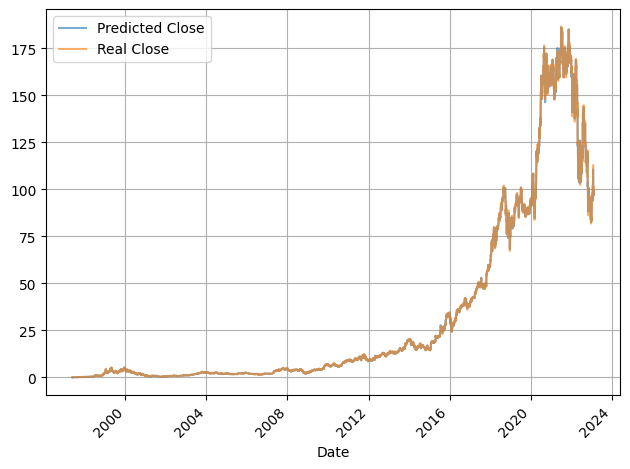

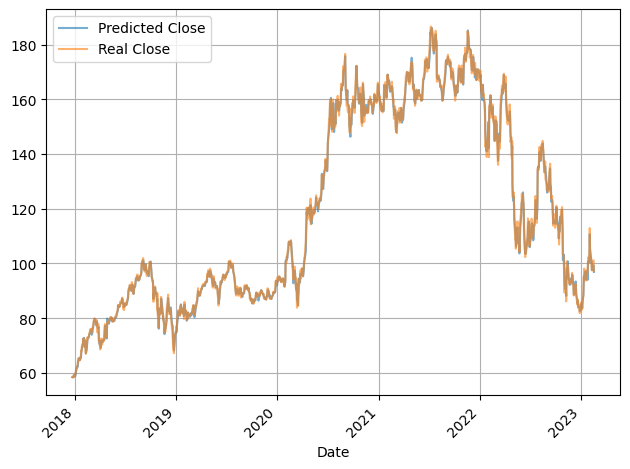

Progress: |██████████████████████████████████████████████████| 100.0% 
  alpha    beta    result
-------  ------  --------
      1     100    0.6489

KNN Regression


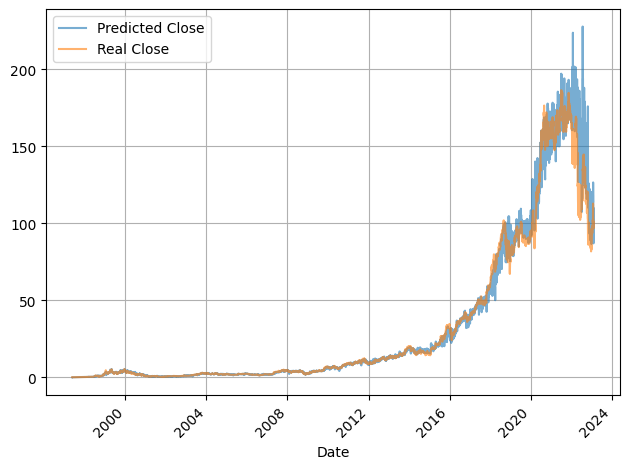

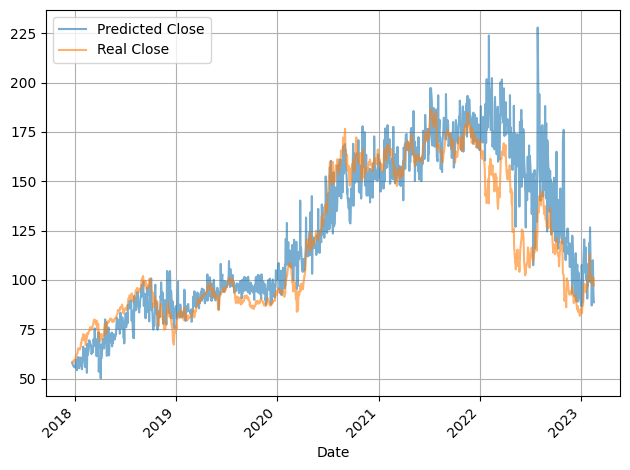

Progress: |██████████████████████████████████████████████████| 100.0% 
  n_neighbors    result
-------------  --------
            3    7.4794

Hoeffding Tree


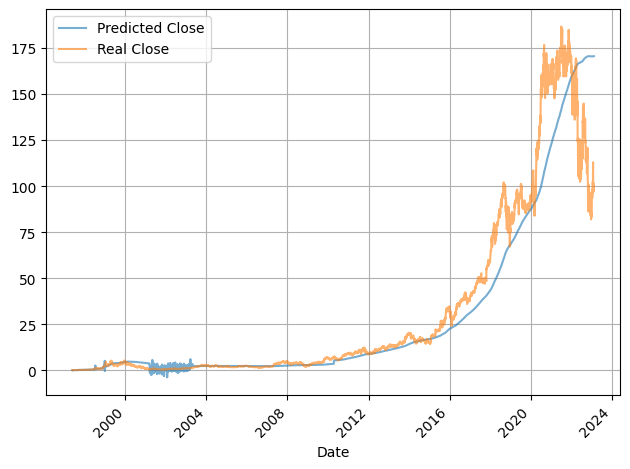

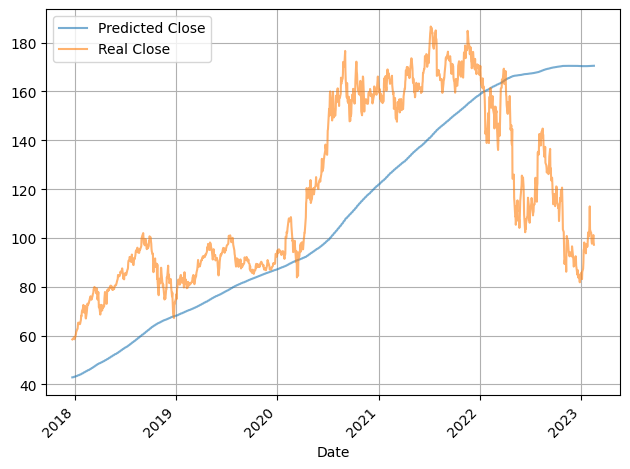

Progress: |██████████████████████████████████████████████████| 100.0% 
  grace_period    max_depth    result
--------------  -----------  --------
            50            1   15.8706

Hoeffding Adaptive Tree


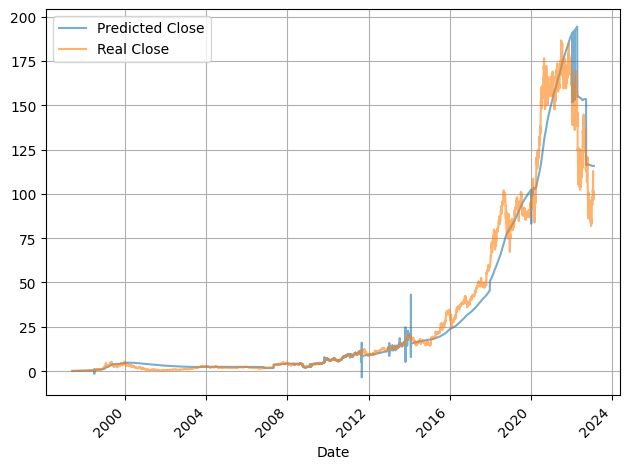

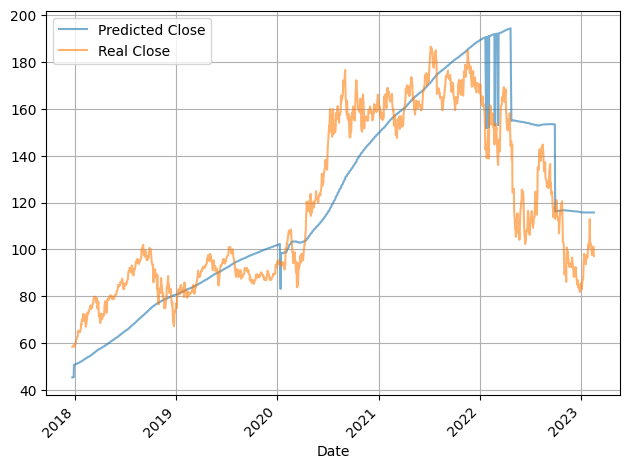

Progress: |██████████████████████████████████████████████████| 100.0% 
  grace_period    max_depth    result
--------------  -----------  --------
           250            1    9.1886

MLP Regression


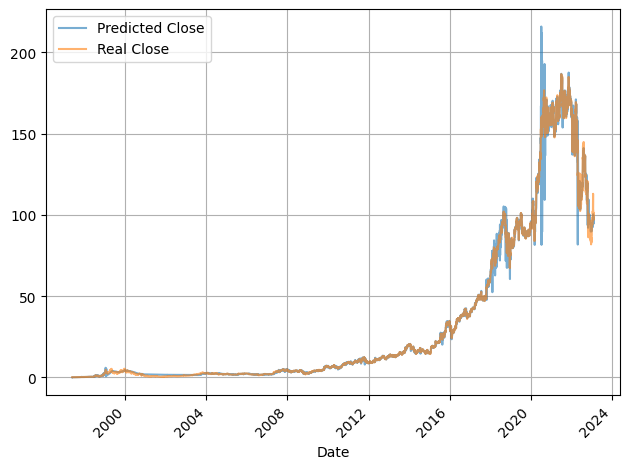

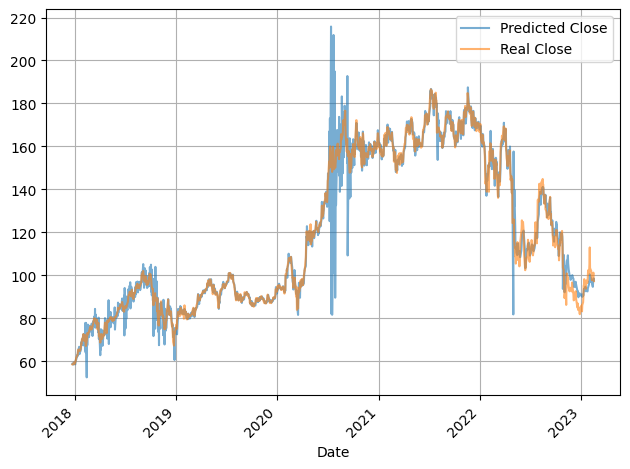

Progress: |██████████████████████████████████████████████████| 100.0% 
hidden_dims      result
-------------  --------
(4, 4)           3.0874



In [16]:
# Default params
params = {
    'normalize_target': True,
    'plot_results': True
}

####################################
#    Bayesian Linear Regression    #
####################################
params_2_test_bayesian = {
    'alpha': [1],
    'beta': [100]
}
bayesian_cv = lambda **params: stream_validate(BayesianLinearRegression, **params)
print("Bayesian Linear Regression")
search_params(bayesian_cv, params, params_2_test_bayesian) 

########################
#    KNN Regression    #
########################
params_2_test_knn = {
    'n_neighbors': [3]
}
knn_cv = lambda **params: stream_validate(KNNRegressor, **params)
print("KNN Regression")
search_params(knn_cv, params, params_2_test_knn)

########################
#    Hoeffding Tree    #
########################
params_2_test_hoeffding = {
    'grace_period': [50],
    'max_depth': [1]
}
hoeffding_cv = lambda **params: stream_validate(HoeffdingTreeRegressor, **params)
print("Hoeffding Tree")
search_params(hoeffding_cv, params, params_2_test_hoeffding)

#################################
#    Hoeffding Adaptive Tree    #
#################################
params_2_test_hoeffding_adaptive = {
    'grace_period': [250],
    'max_depth': [1]
}
hoeffding_adaptive_cv = lambda **params: stream_validate(HoeffdingAdaptiveTreeRegressor, **params)
print("Hoeffding Adaptive Tree")
search_params(hoeffding_adaptive_cv, params, params_2_test_hoeffding_adaptive)

######################
#    MLP Regression  #
######################
params_2_test_mlp = {
    'hidden_dims': [((4, 4),(ReLU, ReLU, ReLU, Identity))]
}
mlp_cv = lambda **params: stream_validate(MLPRegressor, **params)
print("MLP Regression")
search_params(mlp_cv, params, params_2_test_mlp)

## 7. Discussion

In this section, we will discuss the results obtained for the batch learning and the stream learning. First, we will analyse the performance in each type of learning individually, and then we will finish comparing both.

In all the experiments, a bayesian linear regressor, a multi-layer perceptron (MLP), a kNN, a Hoeffding tree regressor and its adaptative variation, were selected to evaluate. Different configurations have been tested, trying to find the best hyperparameters combination. The best configuration of each type of model was selected to perform a final hold out experiment in the case of batch learning. In the case of stream learning, we cannot distinguish between train and test, but we showed only plots of the best configuration of each type.

For the bayesian regressor, values of alpha and beta of 1, 10 or 100 were tested. For the kNN, a value of k of 3, 5, 7, 9 or 11 were tested. For the Hoeffding tree and its adaptative version, graces period of 50, 100, 250 or 500 and a maximum depth of 1, 2, 3, 10 or unlimited were tested. For the MLP, neural networks with 0 hidden layers, one hidden layer with 4, 16 or 64 neurons, and 2 hidden layers with (4,4), (16,4) and (16,16) were tested. The rest of parameters were the default in the river library.

### Batch learning (results in Section 5)

Starting with the **cross-validation** step, (average) results for the **bayesian regressor** range between [5.4894, 8.3957] with standard deviation between 1-4, except for the configuration with alpha=100 and beta=1 that shows the highest variation of 6.2619. The configuration with the lowest mean is the ones with alpha=beta. Here we can clearly see that different results are obtained only when the proportion alpha/beta is different. About the **kNN**, the lower the value of k (number of neighbors) the better the results, being the configuration with k=3 the best with a mean of 2.8598. However, the results are very similar, being the worst 3.0035 corresponding to k=11. The variation follows the same tendency, increasing as k increases and with small differences between the configurations. For all of them, the variation ranges between [3.6, 3.9]. As for the **Hoeffding tree**, we see that after a maximum depth of 3, we obtain the same results for the same grace period. In this case, the results vary between 1.6218 (the best among all the models), corresponding to a grace period=500, and 3.8408 for a grace period=250 and maximum depth=1. We observe higher standard deviations than for the previous models, with values between 3.7806 for the best configuration and 10.4572 for the worst. In the case of the **adaptative version**, the results are a little bit worse. The best result corresponds to the configuration with grace period=50 and maximum depth=10 or unlimited, with a value of 2.4351 and a variation of 4.6272. The worst corresponds to a grace period=500 and a maximum depth=2 with a mean result of 5.0748 and a variation of 10.8858. Last, for the **MLP** the results vary between a mean of 5.2015 ± 2.4680 for the configuration with (4,4) hidden neurons and 9.5159 ± 8.5614 for the one with (16,4) hidden neurons.
In general, from these results we would expect that the best performing models in the test set would be the kNN or the Hoeffding tree, but as we will see now this is not true.

Checking now the plots corresponding to the **prediction on a test set** (after training in the whole training set without cross-validation), we see that the model with the best results is the **bayesian regressor**. Not only because its RMSE in test is much lower than for the other values, but because the signal it produces is very similar to the original one, just shifted around 20 points (approximately the RMSE) vertically. In the case of the **kNN**, it is not able to produce close values above 60, which would correspond to the close value in the ground-truth for the test set. However, it is interesing that when the original signal experiments strong decreases, the signal of the kNN also experiments negative peaks. For the **Hoeffding tree**, with a RMSE of 78.0528, a little bit higher than for the kNN, we see that the output experiments large variations. Although it goes up and down constantly, we see that it "fits" the original signal, in the sense that it makes very accurate approximations every short time intervals. The **adaptative tree variation** is the worse, with a RMSE of 102.484. From the figure, we see that it always return the same value, around 25. Contrary to the kNN, in this case the signal does not even experiment peaks, it is just a flat response. Finally, the **MLP** obtains an RMSE of 33.6471, the second best. We see that in general the predictions follows the original signal, but with a lot of noise. It seems that it understands when the tendency goes up or down, but not the intensity of the change.

To conclude this section, we attach the bad results not only to the difficulties of these type of models to predict time series on new samples (no memory), but to the fact that the test set corresponds to an interval of time where the magnitude of the stock price is highly greater than in the past (train samples), time when the values were more constant and therefore easier to predict. This would explain why for example the kNN does not go above a value of 60. It would also explain why the results in the cross-validation approach are much better than for the hold-out, since the validation set would be also the last samples but they would correspond to flatter signals more similar to the training set. Regarding positive aspects, we were greatly surprised about the performance of the bayesian regressor and, in a shorter extent, the MLP.


### Stream learning (results in Section 6)

In this case there is no cross-validation approximation, since all the samples are used as test and train. Therefore we will comment directly the results calculated after iterating all over the dataset. 

As before, we will start with the **numerical analysis**, finishing with a discussion about the plots. For the **bayesian regressor**, we obtain the best RMSE among all the models (0.6489) for the configuration with alpha=1 and beta=100, but also very bad results as the one with alpha=100 and beta=1 with an RMSE of 33.8932. The rest of configuration vary a lot, obtaining results of ~2 or ~12 points. About the **kNN**, the results are quite similar for all the configuration, between 7.4794 and 8.8476, corresponding to k=3 and k=11, respectively. In the case of the **Hoeffding tree**, all the results are also kind of similar, between 15.3352 (grace period=500 and maximum depth=1) and 16.5318 (grace period=250 and maximum depth>1). The **adaptive version** reduces the RMSE for all the configurations except for a grace period=100. Specificcaly, the best configuration with a grace period=250 and maximum depth=1 achieves an RMSE of 9.1886, while the ones with grace period=100 obtains 18.3308. As in the case of the bayesian regressor, the **MLP** also shows a lot of variance across configurations. While the best configuration with (4,4) hidden neurons achieves an RMSE of 3.0874, the worst with (64,) or (16,4) hidden neurons obtain 47.9595. This time, the numerical results are in accordance with the plots, since the bayesian regressor and the MLP obtain the lowest RMSE and shows a prediction signal very similar to the ground-truth.

**Checking the plots**, the predictions of the **bayesian regressor** are practically identical to the original signal. We do not observe any particular exception on the whole dataset. For the **kNN**, it seems that starts quite well in the first years (what would correspond to the training set in the batch learning approach), but after the upwards tendency in 2012, the prediction starts to diverge more and more from the ground-truth. This effect is clearly visible from 2022 until now, where most of the predictions are above the real values. For the **Hoeffding tree**, a very bad fit is observed. In general terms, it follows the macro tendency of the price, except for the downwards tendency after 2021. However, it does not fit particularly well the micro changes in short periods of time. That results in a smooth predicted signal that in general follows the original signal but that is unable to fit the actual values of the stock. In the case of the **adaptative version**, some improvements are observed. First, the prediction also decreases after 2021. Second, although it is also a smooth signal, it fits better the actual values. Lastly, the **MLP** experiments a very good behaviour before 2016, as the kNNs, but it gets confused in some parts after that, for example in the middle of 2020-2021 or in the large decrease after 2022. However, in general it fits relatively well the original signal.

To conclude, all of the models are able to follow, in some degree, the tendency of the stock price. Some of them fit really well the actual values and the micro tendency changes, such as the bayesian regressor or the MLP. Other, as the kNN, detect the micro changes but experiment some difficulties to accurately predict the value, so they show a large variance with respect to the original signal. Finally, trees are only able to follow the macro tendency, but are completely unable to learn the micro changes and predict values similar to the ones with are looking for.


### Batch learning vs Stream learning

Having the individual models and each of the learning approaches commented individually, let's analyse now the differences between a batch and stream learning approach to model time series. There are clearly no doubts about the superior performance of the stream versions over the batch. In some models, we observe an improvement over x10, changing from ~20 to <1 in the case of the bayesian regressor, from ~33 to ~3 for the MLP, from ~75 to ~7 for the kNN, or ~100 to ~9 for the adaptative Hoeffding tree (notice that these numbers correspond to the RMSE on the test set for batch and to the whole dataset for stream). From the plots, although the bayesian already output a kind of similar signal to the original one in the case of batch learning, the stream version is able to almost fit it perfectly. For the MLP, the fit is much better on stream, although it still experiments some variations when the tendency changes drastically. In the case of the kNN, the results have nothing to do with each other. While on the batch approach it did not predict one sample well, remaining all of them between the value of 60, on the online approach it is able to follow the signal and predict relatively well some of the prices, with a lot of magnitude variation in some cases. Lastly, the online trees are bad, but not as bad as in in the batch approach. In online they are able to follow at least the macro tendency, while in the batch the show a constant signal or one that changes from the actual value to 0 every short period of time.

Therefore, it should finally be emphasized that the poorer performance caused by batch learning is clearly linked to the use of outdated samples and the failure to handle changes in data distribution (concept drift) when making predictions.


## 8. Conclusions and Future work

To finish this project, we explain the main conclusions extracted from the results:

- **Stream learning is clearly superior** to batch learning for a time series problem such as stock market forecasting.
- In a **batch learning** approach, the change is not modeled correctly, so the **models are extremely affected by concept drifts**.
- **Hoeffding trees are not accurate on regression problems**.
- The **bayesian approach is the best option for batch or stream learning**, among the options considered for this project. However, the **MLP also shows a relatively good performance**.

To continue this project in the feature, we also provide some options:
- **Try different models and datasets** to complement the insights extracted here over new type of models or to confirm the conclusions on other time series datasets.
- **Try a deep learning approach** suitable for this kind of problem, such as recurrent networks or LSTM, which by default are designed with a kind of memory that can be useful to improve the accuracy, at least, in short term.
- **Extract new features** such as market indicators (e.g. AARON, Bollinger Bands) that can provide the samples with richer contextual information so the prediction can be estimated easier.